In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

By opening the file that way, the Chinese characters will be removed:

In [2]:
with open('../data/labelled_data.csv', encoding='ascii', errors='ignore') as myfile:
    abstracts = pd.read_csv(myfile, index_col=0)

In [3]:
abstracts.head()

,abstract,significant
0,bone. 2018 sep 24. pii: s8756-3282(18)30355-7....,0.0
1,neurosci lett. 2018 sep 24. pii: s0304-3940(18...,yes
2,fetal pediatr pathol. 2018 sep 27:1-11. doi: 1...,yes
3,per med. 2018 sep 27. doi: 10.2217/pme-2018-00...,both
4,endokrynol pol. 2018 sep 27. doi: 10.5603/ep.a...,yes


### Cleaning of abstracts
Abstracts which are shorter than 500 characters (see labelling_of_significance_of_results for details) are removed, numbers in words are transformed to a synonyme and words are fused or expanded to not be removed by the cleaning, numbers are removed, punctuation is removed and words shorter than three characters are removed.

In [4]:
# removing abstracts shorter than 500 characters - for details see labelling_of_significance_of_results
abstracts['abstract_length'] = abstracts.abstract.str.len()
abstracts = abstracts[abstracts['abstract_length'] > 500]
abstracts = abstracts.drop('abstract_length', axis=1)

In [5]:
def easy_words(column):
    text = column.str.lower()
    
    text = text.str.replace('1,25\S+ vitamin d', 'calcitriol')
    text = text.str.replace('1,25\S+ vit d', 'calcitriol')
    text = text.str.replace('1,25\S+', 'calcitriol')

    text = text.str.replace('1,25 vitamin d', 'calcitriol')
    text = text.str.replace('1,25 vit d', 'calcitriol')
    text = text.str.replace('1,25 \S+ vitamin d', 'calcitriol')
    text = text.str.replace('1,25 \S+ vit d', 'calcitriol')
    text = text.str.replace('1,25 \S+ d', 'calcitriol')
    text = text.str.replace('1,25 \S+', 'calcitriol')
    
    text = text.str.replace('25\S+ vitamin d', 'calcitriol')
    text = text.str.replace('25\S+ vit d', 'calcitriol')
    text = text.str.replace('25\S+', 'calcitriol')
 
    text = text.str.replace('vitamin d', 'vitamind')
    text = text.str.replace('vit d', 'vitamind')
    
    text = text.str.replace('tb', 'tuberculosis')
    
    return text

In [6]:
abstracts['abstract'] = easy_words(abstracts['abstract'])

In [7]:
abstracts['abstract'] = abstracts.abstract.str.replace('\d+', '')

In [8]:
abstracts['abstract'] = abstracts.abstract.str.replace('[^\w\s]', '')

In [9]:
abstracts['abstract'] = abstracts.abstract.str.findall('\w{3,}').str.join(' ')

### Split labelled from unlabelled data

In [10]:
unlabelled_abstracts = abstracts[abstracts['significant'] == '0.0']
unlabelled_abstracts = unlabelled_abstracts.drop('significant', axis=1)

labelled_abstracts = abstracts[abstracts['significant'] != '0.0']

In [11]:
print(f'{len(labelled_abstracts)} labelled abstracts.')
print(f'{len(unlabelled_abstracts)} unlabelled abstracts.')

21752 labelled abstracts.
3228 unlabelled abstracts.


### Splitting data in train, validate, test

In [12]:
def split_train_val_test(data, targetname, percentages):
    """percentages = list with percentage of train,val,test. e.g. [0.6,0.2,0.2]
    targetname = column name of target (string). data is a dataframe"""
    train_perc = percentages[0]
    test_perc = percentages[2]
    val_perc = test_perc/(train_perc + test_perc)

    if sum(percentages) > 1:
        print('percentages don\'t sum up to more than 1! calculate again :) ')
        return None
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            data.loc[:, data.columns != targetname], data[targetname],
            test_size=test_perc, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=val_perc, random_state=42)
        return [X_train, X_val, X_test, y_train, y_val, y_test]

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(labelled_abstracts, 'significant',
                                                                      [0.7, 0.15, 0.15])

### CountVectorizing vs. TF-IDF for getting a word/frequency matrix
min_df was set to 0.02 to ensure the very low frequency words (in our case probably authors and university names) are removed.

In [14]:
cv = CountVectorizer(min_df=0.02, max_features=300000, stop_words='english').fit(X_train['abstract'])

In [15]:
tf = TfidfVectorizer(min_df=0.02, max_features=300000, stop_words='english').fit(X_train['abstract'])

In [16]:
def count_vect(series):
    matrix = cv.transform(series)
    features = cv.get_feature_names()
    df = pd.DataFrame(matrix.todense(), columns=features)
    return df


def tf_idf(series):
    matrix = tf.transform(series)
    features = tf.get_feature_names()
    df = pd.DataFrame(matrix.todense(), columns=features)
    return df

In [17]:
cv_train_df = count_vect(X_train['abstract'])
cv_val_df = count_vect(X_val['abstract'])
cv_test_df = count_vect(X_test['abstract'])

In [18]:
cv_train_df.head()

,ability,abnormalities,absence,absorptiometry,absorption,according,achieved,acid,action,activation,...,wiley,winter,women,womens,xray,year,years,york,young,zhang
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [19]:
tf_train_df = tf_idf(X_train['abstract'])
tf_val_df = tf_idf(X_val['abstract'])
tf_test_df = tf_idf(X_test['abstract'])

In [20]:
tf_train_df.head()

,ability,abnormalities,absence,absorptiometry,absorption,according,achieved,acid,action,activation,...,wiley,winter,women,womens,xray,year,years,york,young,zhang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.133627,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.115806,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.072114,0.0,0.0,0.064535,...,0.000000,0.0,0.03813,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### Checking for linearity

In [21]:
cv_train_df.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [22]:
cv_df = pd.concat((cv_train_df, y_train), axis=1)

In [23]:
tf_train_df.reset_index(drop=True, inplace=True)

In [24]:
tf_df = pd.concat((tf_train_df, y_train), axis=1)

In [25]:
corr_matrix = cv_df.corr()
corr_matrix['significant'].sort_values(ascending=False)

significant      1.000000
statistically    0.245461
difference       0.232387
differences      0.175333
observed         0.151545
correlation      0.139672
reduction        0.127332
increase         0.121363
decrease         0.121075
showed           0.120268
association      0.117615
improvement      0.106613
study            0.104781
changes          0.099856
groups           0.098712
iran             0.096864
correlations     0.092166
months           0.090632
bmd              0.089947
spine            0.089406
lumbar           0.088751
placebo          0.087528
inverse          0.086779
studies          0.086728
group            0.086232
effect           0.085799
randomized       0.083800
positive         0.082937
change           0.076879
total            0.075705
                   ...   
calcitriol      -0.037160
inhibition      -0.038124
involved        -0.039362
vitro           -0.039402
induced         -0.041417
rat             -0.041497
protein         -0.044577
mouse       

In [26]:
corr_matrix = tf_df.corr()
corr_matrix['significant'].sort_values(ascending=False)

significant      1.000000
statistically    0.216156
difference       0.215813
differences      0.162295
pmid             0.152889
observed         0.141773
correlation      0.137859
increase         0.134501
decrease         0.132965
showed           0.116469
improvement      0.114398
reduction        0.103604
changes          0.095679
medline          0.093882
indexed          0.090399
association      0.088037
groups           0.084126
effect           0.081179
correlations     0.079756
months           0.076212
change           0.074505
positive         0.071444
resulted         0.070563
study            0.070532
inverse          0.067217
iran             0.061939
seen             0.061301
noted            0.059647
treatment        0.057754
placebo          0.055577
                   ...   
protein         -0.039348
production      -0.039377
fold            -0.039649
inhibitor       -0.039890
school          -0.039903
stimulated      -0.039991
compared        -0.040862
university  

There is a weak linear correlation between statistically, difference, significantly, differences, observed, 
correlation, reduction, increase, decrease, showed, association, improvement, study and the target - not surprisingly as these words are usually part of a statement of significance.

### MVP - Logistic Regression
- Logistic Regression is a first, easy model to classify data
- there is a linear relationship between three features and the target

Using count vectorized input data.

In [27]:
logreg_cv = LogisticRegression(random_state=42).fit(cv_train_df, y_train)

In [28]:
def cm(y_train, y_train_predict, y_val, y_val_predict):
    cm_train = confusion_matrix(y_train, y_train_predict, labels=['yes', 'no', 'both'])
    cm_train_percentage = cm_train/(cm_train.sum(axis=1, keepdims=True))

    cm_val = confusion_matrix(y_val, y_val_predict, labels=['yes', 'no', 'both'])
    cm_val_percentage = cm_val/(cm_val.sum(axis=1, keepdims=True))
    
    sns.set(font_scale=1.3)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.heatmap(cm_train_percentage, annot=True, xticklabels=['yes', 'no', 'both'],
                yticklabels=['yes', 'no', 'both'], fmt='.2f')
    plt.title('TRAIN')
    plt.subplot(1,2,2)
    sns.heatmap(cm_val_percentage, annot=True, xticklabels=['yes', 'no', 'both'],
                yticklabels=['yes', 'no', 'both'], fmt='.2f')
    plt.title('VALIDATE')
    plt.show()
    
    
def evaluate_model(model, X_train, y_train, X_val, y_val):
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    
    print(f'Accuracy for predicting the train labels: {np.round(train_score, decimals=2)}')
    print(f'Accuracy for predicting the validate labels: {np.round(val_score, decimals=2)}')
    
    predict_train = model.predict(X_train)
    predict_val = model.predict(X_val)
    
    cm(y_train, predict_train, y_val, predict_val)
    
    print(classification_report(y_val, predict_val))

Accuracy for predicting the train labels: 0.8
Accuracy for predicting the validate labels: 0.75


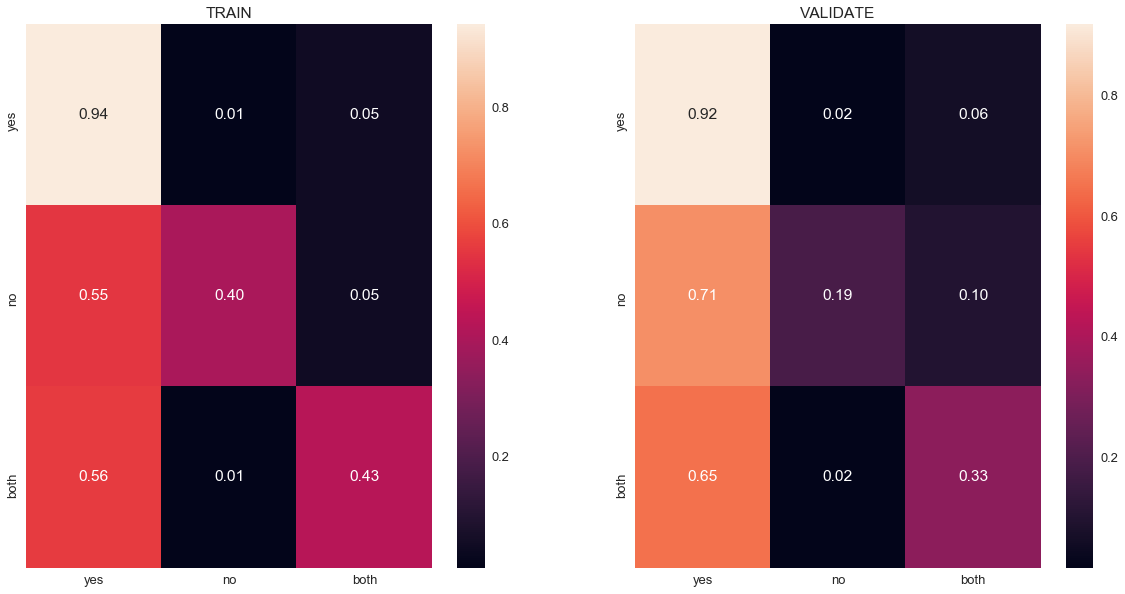

             precision    recall  f1-score   support

       both       0.56      0.33      0.42       658
         no       0.44      0.19      0.26       228
        yes       0.79      0.92      0.85      2377

avg / total       0.72      0.75      0.72      3263



In [29]:
evaluate_model(logreg_cv, cv_train_df, y_train, cv_val_df, y_val)

Most of the 'yes' papers were correctly classified (92 %), however, 'no' (18 %) and 'both' (33 %) posed difficulties, especially 'no'. Maybe this is because the major proportion of papers in the training data are labelled as 'yes'.

Precision: 69 % is correctly classified as 'both', 32 % is classified as 'both' even though it's truly 'no' or 'yes'.

Recall: 24 % is correctly classified as both, but 76 % of 'both' is wrongly classified as 'yes' or 'no'.

f1-score: harmonic mean of precision and recall.

#### Logistic regression is trained with TF-IDF pre-processed data.

In [30]:
logreg_tf = LogisticRegression(random_state=42).fit(tf_train_df, y_train)

Accuracy for predicting the train labels: 0.76
Accuracy for predicting the validate labels: 0.74


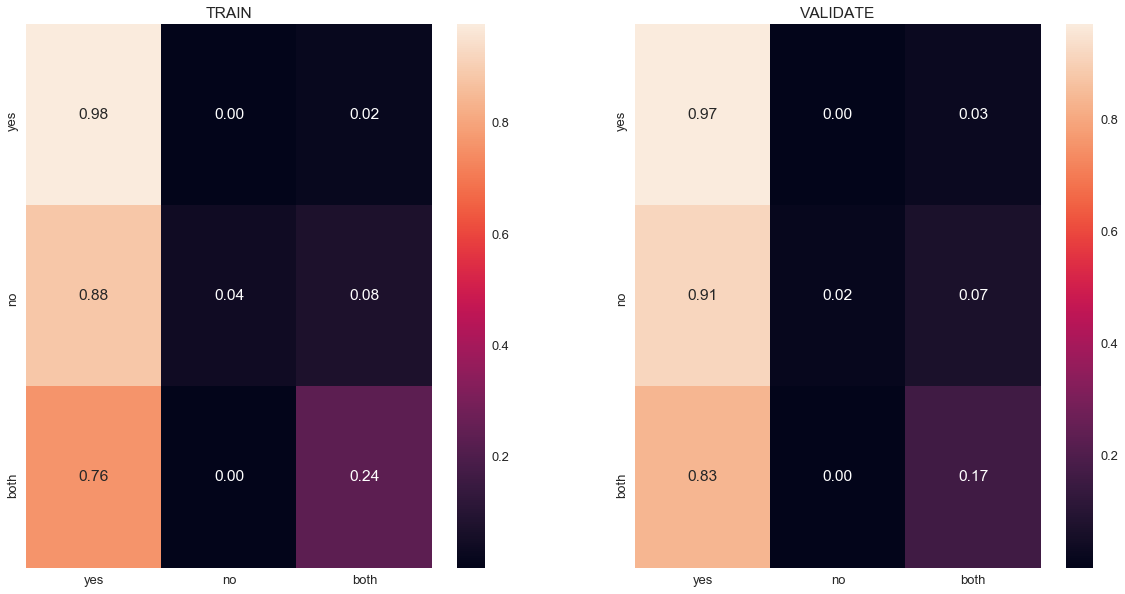

             precision    recall  f1-score   support

       both       0.55      0.17      0.25       658
         no       0.57      0.02      0.03       228
        yes       0.75      0.97      0.85      2377

avg / total       0.70      0.74      0.67      3263



In [31]:
evaluate_model(logreg_tf, tf_train_df, y_train, tf_val_df, y_val)

TF-IDF was better with classifying the 'yes' (97 % correct), however much worse with 'no' (1.3 % correct) and 'both' (17% correct). CountVectorize will be used for data preprocessing from here on out.

### Support Vector Machines
- Support Vector Machines do very well on wide data (lots of features) without overfitting
- they are able to work with unbalanced classes by balancing them automatically as is the case with this data
- This paper (http://www.cs.cornell.edu/~tj/publications/joachims_98a.pdf) suggested the kernel 'poly' and 'rbf' work very well for text

In [32]:
sv_poly = SVC(kernel='poly', class_weight='balanced', C=1.0, random_state=42).fit(cv_train_df, y_train)

Accuracy for predicting the train labels: 0.76
Accuracy for predicting the validate labels: 0.71


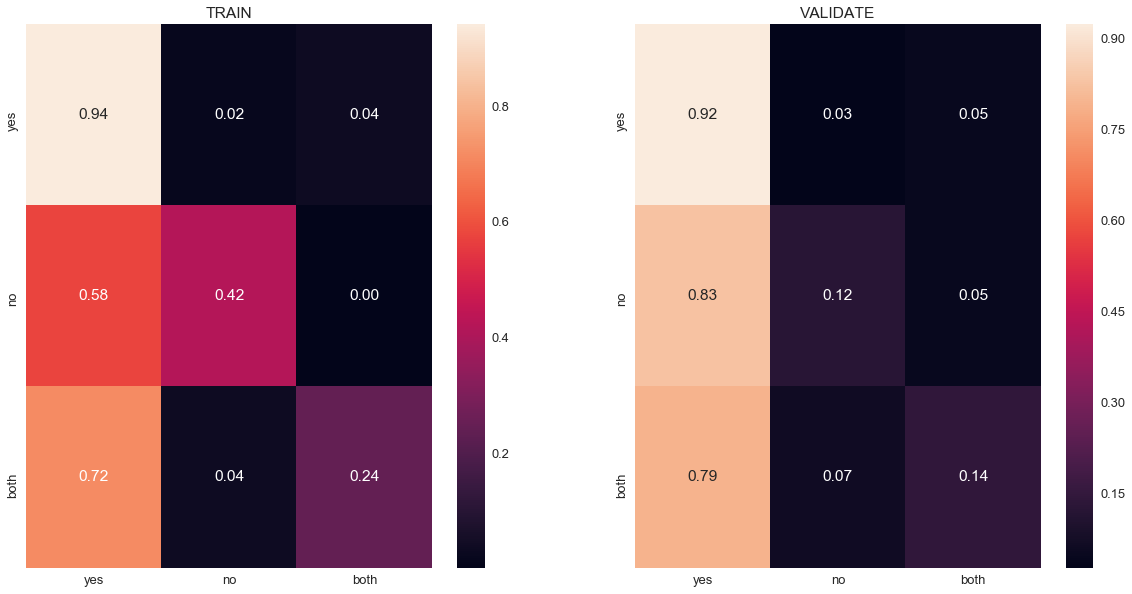

             precision    recall  f1-score   support

       both       0.43      0.14      0.21       658
         no       0.20      0.12      0.15       228
        yes       0.76      0.92      0.83      2377

avg / total       0.65      0.71      0.66      3263



In [33]:
evaluate_model(sv_poly, cv_train_df, y_train, cv_val_df, y_val)

Support Vector Machine with polynomial kernel does worse than the Logistic Regression.

#### Support Vector Machine with rbf-kernel

In [34]:
sv_rbf = SVC(kernel='rbf', class_weight='balanced', C=1.0, random_state=42).fit(cv_train_df, y_train)

Accuracy for predicting the train labels: 0.71
Accuracy for predicting the validate labels: 0.64


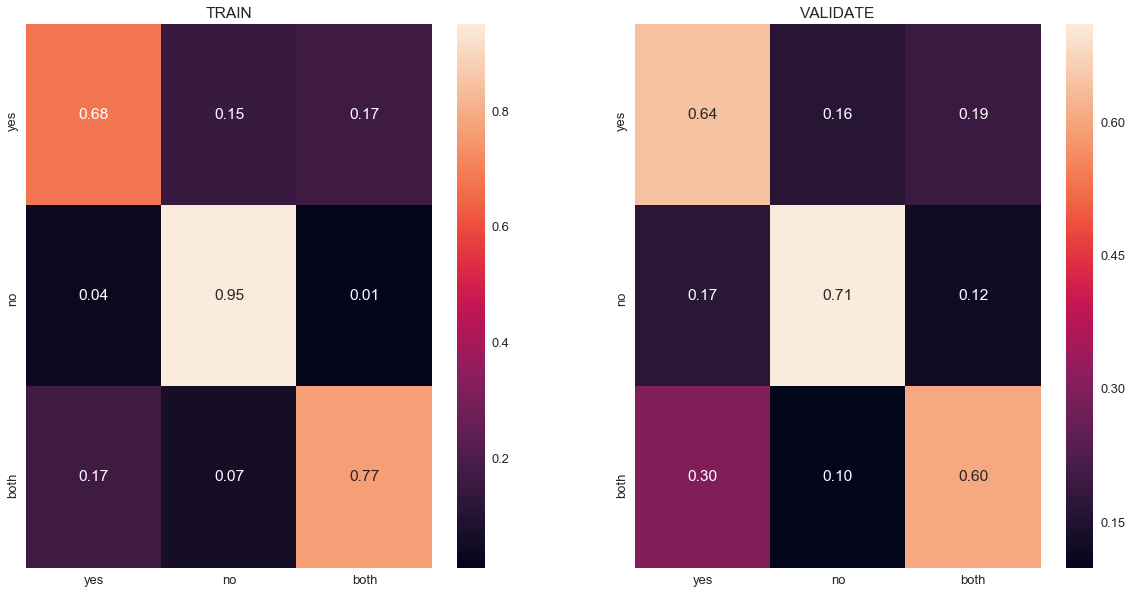

             precision    recall  f1-score   support

       both       0.45      0.60      0.51       658
         no       0.26      0.71      0.38       228
        yes       0.87      0.64      0.74      2377

avg / total       0.74      0.64      0.67      3263



In [35]:
evaluate_model(sv_rbf, cv_train_df, y_train, cv_val_df, y_val)

The rbf kernel does quite well. It's much worse than Logistic Regression at recognising 'yes' publications but is able to classify 'no' and 'both' quite okay.

#### Support Vector Machine with linear-kernel
Since Logistic Regression as a linear algorithm does kind of okay, the linear kernel is also tried.

In [36]:
sv_linear = SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=42).fit(cv_train_df, y_train)

Accuracy for predicting the train labels: 0.74
Accuracy for predicting the validate labels: 0.62


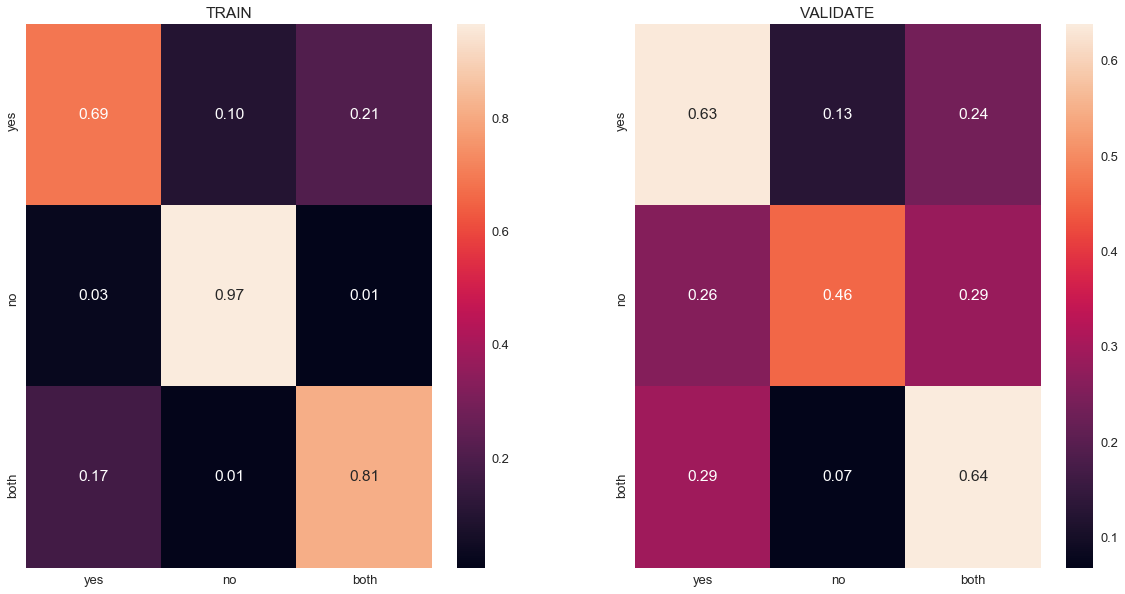

             precision    recall  f1-score   support

       both       0.40      0.64      0.49       658
         no       0.23      0.46      0.30       228
        yes       0.86      0.63      0.73      2377

avg / total       0.72      0.62      0.65      3263



In [37]:
evaluate_model(sv_linear, cv_train_df, y_train, cv_val_df, y_val)

SVM with linear kernel performs better than Logistic Regression.

### Logistic Regression with balanced classes
- the classes are equally balanced in the following as highly unbalanced classes might pose a problem

In [38]:
labelled_abstracts.groupby('significant').count()

,abstract
significant,
both,4279
no,1656
yes,15817


In [39]:
yes = labelled_abstracts[labelled_abstracts['significant'] == 'yes']

In [40]:
yes_sample = yes.sample(n=1656, random_state=42)

In [41]:
both = labelled_abstracts[labelled_abstracts['significant'] == 'both']

In [42]:
both_sample = both.sample(n=1656, random_state=42)

In [43]:
no = labelled_abstracts[labelled_abstracts['significant'] == 'no']

In [44]:
yes_sample.reset_index(drop=True, inplace=True)
both_sample.reset_index(drop=True, inplace=True)
no.reset_index(drop=True, inplace=True)

In [45]:
equal_data = pd.concat((yes_sample, both_sample, no), axis=0)

In [46]:
equal_data = equal_data.sample(frac=1)
equal_data.reset_index(drop=True, inplace=True)

In [47]:
y_equal = equal_data['significant']

In [48]:
X_equal = equal_data.drop('significant', axis=1)

In [49]:
X_equal_cv = count_vect(X_equal['abstract'])

In [50]:
logreg_equal = LogisticRegression(random_state=42).fit(X_equal_cv, y_equal)

Accuracy for predicting the train labels: 0.81
Accuracy for predicting the validate labels: 0.61


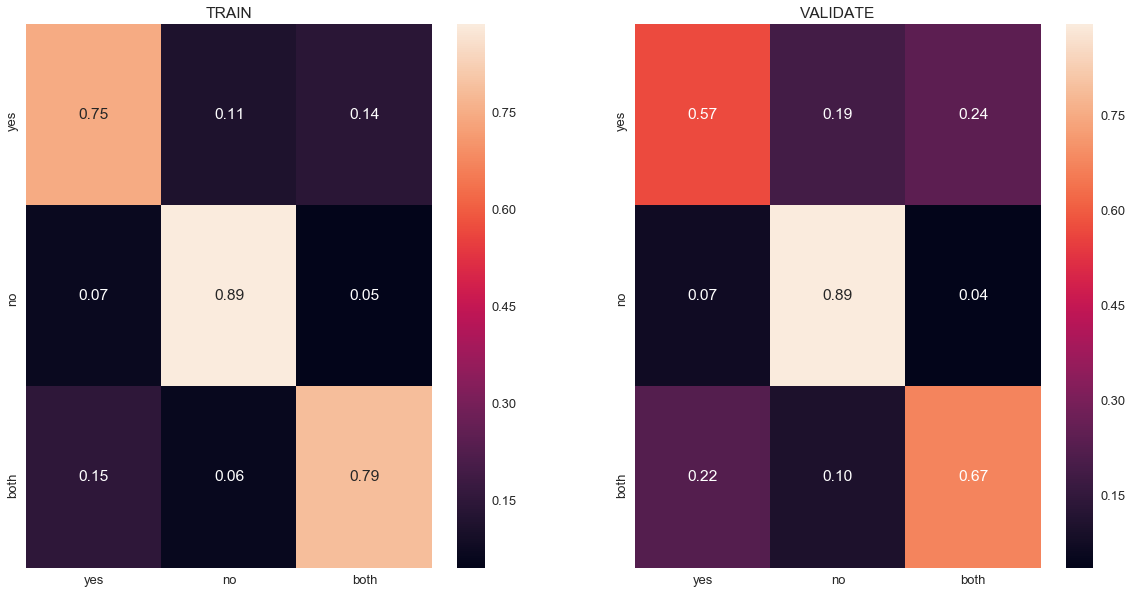

             precision    recall  f1-score   support

       both       0.43      0.67      0.53       658
         no       0.28      0.89      0.43       228
        yes       0.89      0.57      0.70      2377

avg / total       0.76      0.61      0.64      3263



In [51]:
evaluate_model(logreg_equal, X_equal_cv, y_equal, cv_val_df, y_val)

With balanced classes the model is better able to differentiate between the different classes. However, SVM with kernel rbf still perform better.

### Logistic Regression with only the correlated features
- all features that do not have a linear realationship with the target are removed from the DataFrame
- remaining features: statistically, difference and significantly
- the data with balanced classes are used

In [52]:
def lin_features(df):
    lf = pd.DataFrame()
    lf['statistically'] = df['statistically']
    lf['difference'] = df['difference']
    lf['significantly'] = df['significantly']
    lf['differences'] = df['differences']
    lf['observed'] = df['observed']
    lf['correlation'] = df['correlation']
    lf['reduction'] = df['reduction']
    lf['increase'] = df['increase']
    lf['decrease'] = df['decrease']
    lf['showed'] = df['showed']
    lf['association'] = df['association']
    lf['improvement'] = df['improvement']
    lf['study'] = df['study']
    return lf

In [53]:
train_lin = lin_features(X_equal_cv)
val_lin = lin_features(cv_val_df)

In [54]:
logreg_lin = LogisticRegression(random_state=42).fit(train_lin, y_equal)

Accuracy for predicting the train labels: 0.62
Accuracy for predicting the validate labels: 0.5


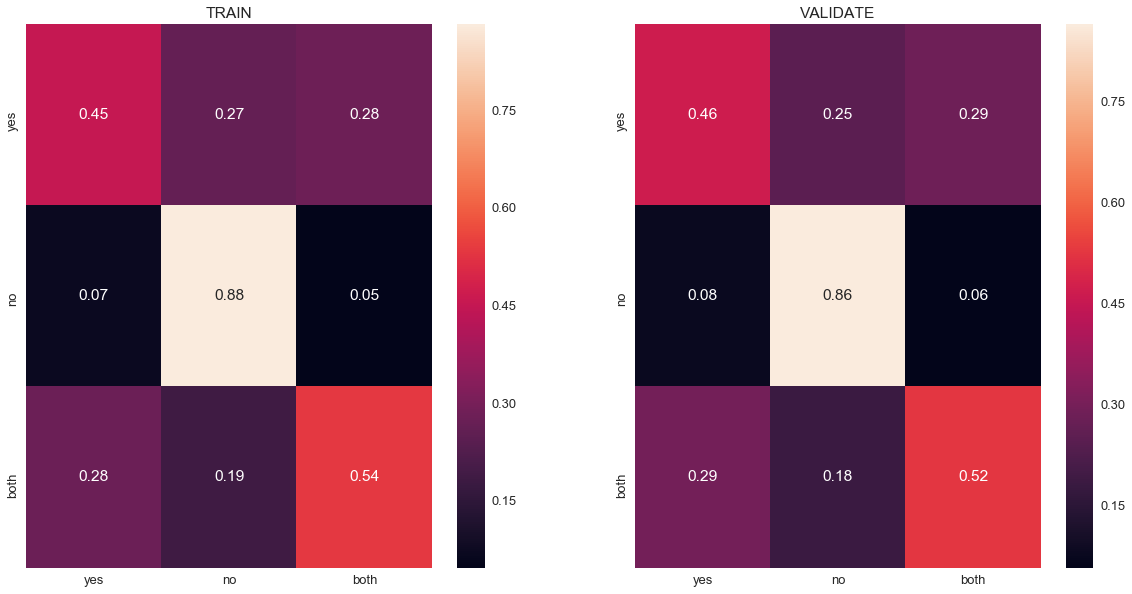

             precision    recall  f1-score   support

       both       0.33      0.52      0.41       658
         no       0.22      0.86      0.35       228
        yes       0.84      0.46      0.60      2377

avg / total       0.69      0.50      0.54      3263



In [55]:
evaluate_model(logreg_lin, train_lin, y_equal, val_lin, y_val)

 Using only features with linear correlation did not improve performance.